In [1]:
# notebook setup

In [2]:
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import requests
import zipfile
import io
from pathlib import Path

import folium
from folium.plugins import DualMap

# python-code-formatter: https://codebeautify.org/python-formatter-beautifier

In [3]:
# google data analytics capstone case
# cyclistic bike share data set dec 2024 to nov 2025

In [4]:
base_url = "https://divvy-tripdata.s3.amazonaws.com/"
out_dir = Path("divvy_parquet")
out_dir.mkdir(exist_ok=True)

months = pd.period_range("2024-12", "2025-11", freq="M")

for m in months:
    file = f"{m.strftime('%Y%m')}-divvy-tripdata.zip"
    url = base_url + file

    r = requests.get(url)
    if r.status_code != 200:
        continue

    with zipfile.ZipFile(io.BytesIO(r.content)) as z:
        csv_name = z.namelist()[0]
        with z.open(csv_name) as f:
            df = pd.read_csv(f)
            df["source_file"] = file

    df.to_parquet(out_dir / f"{m.strftime('%Y%m')}.parquet")
    del df

In [5]:
paths = [
    p
    for p in Path("divvy_parquet").glob("*.parquet")
    if ("2024" in p.stem) or ("2025" in p.stem)
]

df = pd.read_parquet(paths)

In [6]:
# handling missing data

In [7]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5590832 entries, 0 to 5590831
Data columns (total 14 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   ride_id             5590832 non-null  object 
 1   rideable_type       5590832 non-null  object 
 2   started_at          5590832 non-null  object 
 3   ended_at            5590832 non-null  object 
 4   start_station_name  4403894 non-null  object 
 5   start_station_id    4403894 non-null  object 
 6   end_station_name    4346796 non-null  object 
 7   end_station_id      4346796 non-null  object 
 8   start_lat           5590832 non-null  float64
 9   start_lng           5590832 non-null  float64
 10  end_lat             5585288 non-null  float64
 11  end_lng             5585288 non-null  float64
 12  member_casual       5590832 non-null  object 
 13  source_file         5590832 non-null  object 
dtypes: float64(4), object(10)
memory usage: 597.2+ MB


In [8]:
conditions = [
    df["start_station_id"].isna() & df["end_station_id"].notna(),
    df["start_station_id"].notna() & df["end_station_id"].isna(),
    df["start_station_id"].isna() & df["end_station_id"].isna(),
    df["start_station_id"].notna() & df["end_station_id"].notna(),
]
choices = ["dockless_start", "dockless_end", "dockless_both", "standard"]
df["ride_type"] = np.select(conditions, choices, default="standard")

In [9]:
df[["start_station_id", "end_station_id"]] = df[
    ["start_station_id", "end_station_id"]
].fillna("no_station_id")

df[["start_station_name", "end_station_name"]] = df[
    ["start_station_name", "end_station_name"]
].fillna("no_station_name")

In [10]:
df = df.dropna(subset=["start_lat", "start_lng", "end_lat", "end_lng"]).copy()

In [11]:
# improving features

In [12]:
df["started_at"] = pd.to_datetime(df["started_at"], errors="coerce")
df["ended_at"] = pd.to_datetime(df["ended_at"], errors="coerce")

df["day"] = df["started_at"].dt.strftime("%a")
df["day_type"] = np.where(
    (df["day"].isin(["Mon", "Tue", "Wed", "Thu", "Fri"])), "week_day", "week_end"
)

df["hour"] = df["started_at"].dt.hour

season_map = {
    "Dec": "Winter",
    "Jan": "Winter",
    "Feb": "Winter",
    "Mar": "Spring",
    "Apr": "Spring",
    "May": "Spring",
    "Jun": "Summer",
    "Jul": "Summer",
    "Aug": "Summer",
    "Sep": "Fall",
    "Oct": "Fall",
    "Nov": "Fall",
}
df["month"] = df["started_at"].dt.strftime("%b")
df["season"] = df["month"].map(season_map)

In [13]:
df["duration_min"] = (df["ended_at"] - df["started_at"]).dt.total_seconds() / 60

def haversine_np(lat1, lon1, lat2, lon2):
    R = 6371
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)

    a = (
        np.sin(delta_phi / 2.0) ** 2
        + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2
    )

    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c
df["distance_km"] = haversine_np(
    df["start_lat"], df["start_lng"], df["end_lat"], df["end_lng"]
)

df = df[(df["duration_min"] > 0) & (df["distance_km"] > 0)]
df["speed_km_min"] = df["distance_km"] / df["duration_min"]

bins = [0, 0.27, 0.33, 0.42, float("inf")]
labels = ["Slow", "Moderate", "Fast", "Extreme"]
df["speed_category"] = pd.cut(
    df["speed_km_min"], bins=bins, labels=labels, include_lowest=True
)

In [14]:
# duplicate handling

In [15]:
df = df.drop_duplicates()

In [16]:
# final data set

In [17]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 5247982 entries, 0 to 5590831
Data columns (total 24 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   ride_id             5247982 non-null  object        
 1   rideable_type       5247982 non-null  object        
 2   started_at          5247982 non-null  datetime64[ns]
 3   ended_at            5247982 non-null  datetime64[ns]
 4   start_station_name  5247982 non-null  object        
 5   start_station_id    5247982 non-null  object        
 6   end_station_name    5247982 non-null  object        
 7   end_station_id      5247982 non-null  object        
 8   start_lat           5247982 non-null  float64       
 9   start_lng           5247982 non-null  float64       
 10  end_lat             5247982 non-null  float64       
 11  end_lng             5247982 non-null  float64       
 12  member_casual       5247982 non-null  object        
 13  source_file      

In [18]:
# commented out for notebook simplicity
# df_sample = df.sample(5)
# print(tabulate(df_sample, headers="keys", tablefmt="simple"))

In [19]:
df_prop_rideable_type = pd.crosstab(
    df["member_casual"], df["rideable_type"], normalize="index"
)

df_prop_ride_type = pd.crosstab(df["member_casual"], df["ride_type"], normalize="index")

month_order = [
    "Dec",
    "Jan",
    "Feb",
    "Mar",
    "Apr",
    "May",
    "Jun",
    "Jul",
    "Aug",
    "Sep",
    "Oct",
    "Nov",
]
df["month"] = pd.Categorical(df["month"], categories=month_order, ordered=True)
df_prop_month = pd.crosstab(df["member_casual"], df["month"], normalize="index")

season_order = ["Winter", "Spring", "Summer", "Fall"]
df["season"] = pd.Categorical(df["season"], categories=season_order, ordered=True)
df_prop_season = pd.crosstab(df["member_casual"], df["season"], normalize="index")

weekday_order = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
df["day"] = pd.Categorical(df["day"], categories=weekday_order, ordered=True)
df_prop_day = pd.crosstab(df["member_casual"], df["day"], normalize="index")
df_prop_day_type = pd.crosstab(df["member_casual"], df["day_type"], normalize="index")

df_prop_hour = pd.crosstab(df["member_casual"], df["hour"], normalize="index")

df_prop_speed_category = pd.crosstab(
    df["member_casual"], df["speed_category"], normalize="index"
)

df_breakdown = (
    df.groupby(["member_casual"], observed=False).size().reset_index(name="count")
)

In [20]:
# data exploration and analysis

In [21]:
print(tabulate(df_breakdown, headers="keys", tablefmt="simple", floatfmt=".4f"))
# commented out for notebook simplicity
# print()
# print()

# for df_summary in [
#     df_prop_rideable_type,
#     df_prop_ride_type,
#     df_prop_month,
#     df_prop_season,
#     df_prop_day,
#     df_prop_day_type,
#     df_prop_hour,
#     df_prop_speed_category,
# ]:
#     print(tabulate(df_summary, headers="keys", tablefmt="simple", floatfmt=
#     ".4f"))
#     print()
#     print()

    member_casual      count
--  ---------------  -------
 0  casual           1803071
 1  member           3444911


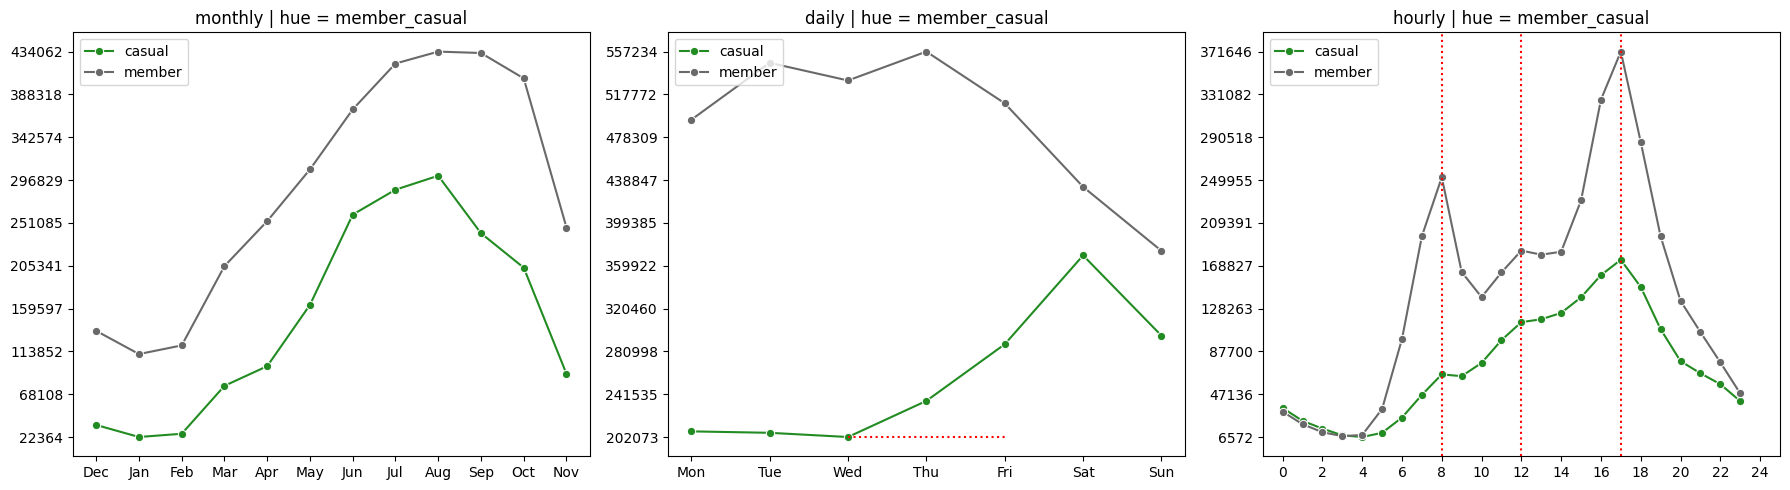

In [22]:
df_summary_month = (
    df.groupby(["member_casual", "month"], observed=False)
    .size()
    .reset_index(name="count")
)

df_summary_day = (
    df.groupby(["member_casual", "day"], observed=False)
    .size()
    .reset_index(name="count")
)

df_summary_hour = (
    df.groupby(["member_casual", "hour"], observed=False)
    .size()
    .reset_index(name="count")
)

color_map = {"casual": "forestgreen", "member": "dimgrey"}

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=False, sharey=False)

sns.lineplot(
    x="month",
    y="count",
    hue="member_casual",
    data=df_summary_month,
    marker="o",
    palette=color_map,
    ax=axes[0],
)
axes[0].set_xlabel("")
axes[0].set_ylabel("")
axes[0].set_yticks(
    ticks=np.linspace(
        int(df_summary_month["count"].min()),
        int(df_summary_month["count"].max()) + 1,
        10,
    )
)
axes[0].set_title("monthly | hue = member_casual")
axes[0].legend(loc="upper left")

sns.lineplot(
    x="day",
    y="count",
    hue="member_casual",
    data=df_summary_day,
    marker="o",
    palette=color_map,
    ax=axes[1],
)
axes[1].set_xlabel("")
axes[1].set_ylabel("")
axes[1].set_yticks(
    ticks=np.linspace(
        int(df_summary_day["count"].min()), int(df_summary_day["count"].max()) + 1, 10
    )
)
axes[1].plot(
    [2, 3, 4],
    [df_summary_day.query("day == 'Wed' and member_casual == 'casual'")["count"]] * 3,
    linestyle=":",
    color="red",
)
axes[1].set_title("daily | hue = member_casual")
axes[1].legend(loc="upper left")

sns.lineplot(
    x="hour",
    y="count",
    hue="member_casual",
    data=df_summary_hour,
    marker="o",
    palette=color_map,
    ax=axes[2],
)
axes[2].set_xlabel("")
axes[2].set_ylabel("")
axes[2].set_xticks(ticks=range(0, 25, 2))
axes[2].set_xlim(-1, 25)
axes[2].set_yticks(
    ticks=np.linspace(
        int(df_summary_hour["count"].min()), int(df_summary_hour["count"].max()) + 1, 10
    )
)
axes[2].axvline(x=8, linestyle=":", color="red")
axes[2].axvline(x=12, linestyle=":", color="red")
axes[2].axvline(x=17, linestyle=":", color="red")
axes[2].set_title("hourly | hue = member_casual")
axes[2].legend(loc="upper left")

plt.tight_layout()
plt.show()

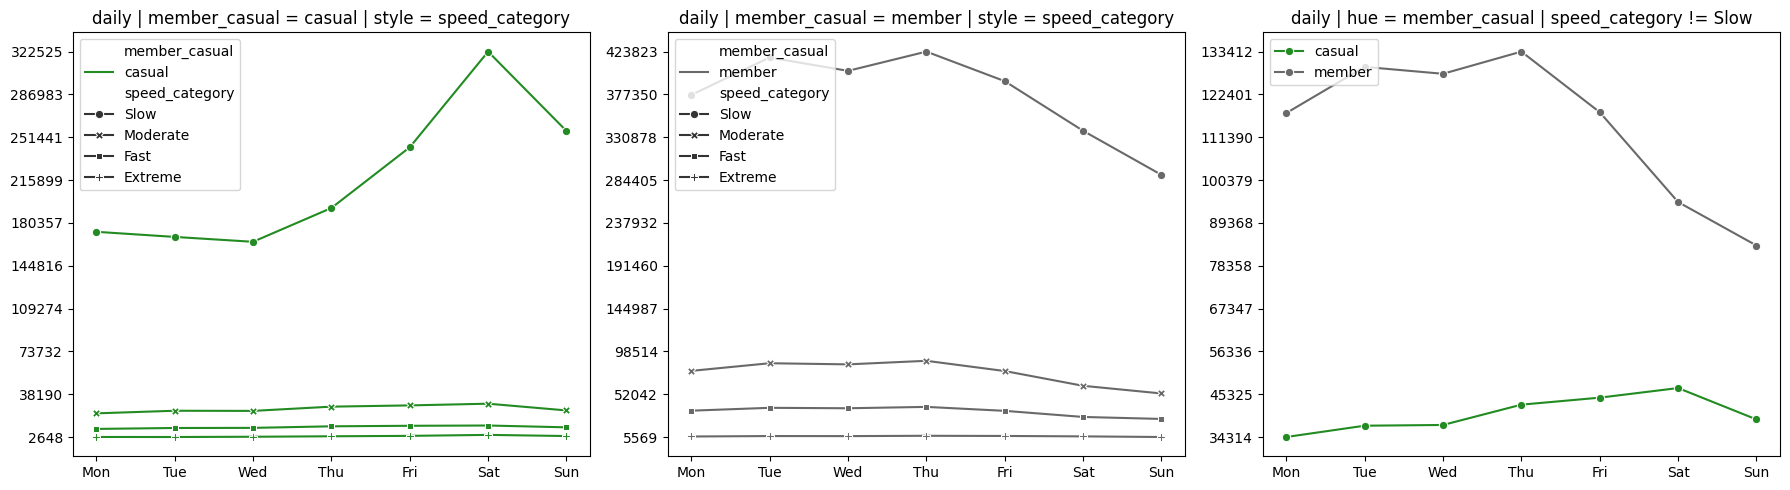

In [23]:
df_summary_day_dd1 = (
    df.query("member_casual == 'casual'")
    .groupby(["member_casual", "day", "speed_category"], observed=False)
    .size()
    .reset_index(name="count")
)

df_summary_day_dd2 = (
    df.query("member_casual == 'member'")
    .groupby(["member_casual", "day", "speed_category"], observed=False)
    .size()
    .reset_index(name="count")
)

df_summary_day_dd3 = (
    df.query("speed_category != 'Slow'")
    .groupby(["member_casual", "day"], observed=False)
    .size()
    .reset_index(name="count")
)

color_map = {"casual": "forestgreen", "member": "dimgrey"}

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=False, sharey=False)
sns.lineplot(
    x="day",
    y="count",
    hue="member_casual",
    style="speed_category",
    data=df_summary_day_dd1,
    markers=True,
    dashes=False,
    palette=color_map,
    ax=axes[0],
)
axes[0].set_xlabel("")
axes[0].set_ylabel("")
axes[0].set_yticks(
    ticks=np.linspace(
        int(df_summary_day_dd1["count"].min()),
        int(df_summary_day_dd1["count"].max()) + 1,
        10,
    )
)
axes[0].set_title("daily | member_casual = casual | style = speed_category")
axes[0].legend(loc="upper left")

sns.lineplot(
    x="day",
    y="count",
    hue="member_casual",
    style="speed_category",
    data=df_summary_day_dd2,
    markers=True,
    dashes=False,
    palette=color_map,
    ax=axes[1],
)
axes[1].set_xlabel("")
axes[1].set_ylabel("")
axes[1].set_yticks(
    ticks=np.linspace(
        int(df_summary_day_dd2["count"].min()),
        int(df_summary_day_dd2["count"].max()) + 1,
        10,
    )
)
axes[1].set_title("daily | member_casual = member | style = speed_category")
axes[1].legend(loc="upper left")

sns.lineplot(
    x="day",
    y="count",
    hue="member_casual",
    data=df_summary_day_dd3,
    marker="o",
    palette=color_map,
    ax=axes[2],
)
axes[2].set_xlabel("")
axes[2].set_ylabel("")
axes[2].set_yticks(
    ticks=np.linspace(
        int(df_summary_day_dd3["count"].min()),
        int(df_summary_day_dd3["count"].max()) + 1,
        10,
    )
)
axes[2].set_title("daily | hue = member_casual | speed_category != Slow")
axes[2].legend(loc="upper left")

plt.tight_layout()
plt.show()

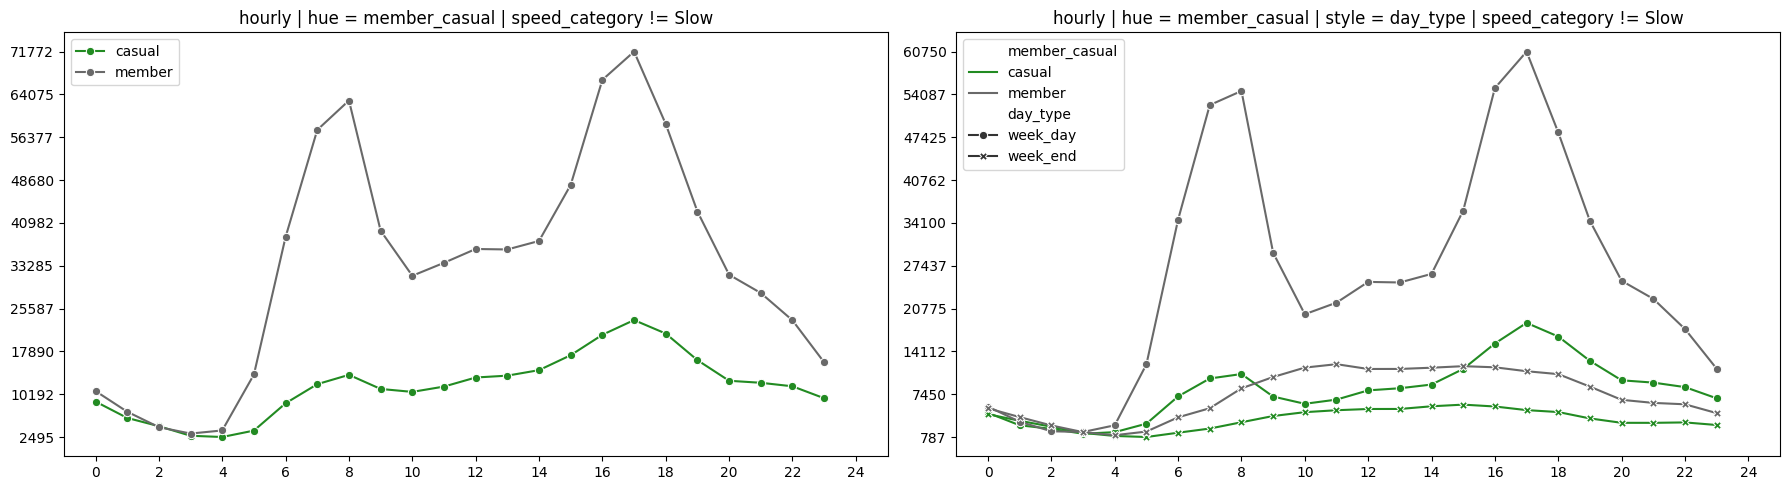

In [24]:
df_summary_hour_dd1 = (
    df.query("speed_category in ('Moderate', 'Fast', 'Extreme')")
    .groupby(["member_casual", "hour"], observed=False)
    .size()
    .reset_index(name="count")
)

df_summary_hour_dd2 = (
    df.query("speed_category in ('Moderate', 'Fast', 'Extreme')")
    .groupby(["member_casual", "hour", "day_type"], observed=False)
    .size()
    .reset_index(name="count")
)

color_map = {"casual": "forestgreen", "member": "dimgrey"}

fig, axes = plt.subplots(1, 2, figsize=(18, 5), sharex=False, sharey=False)
sns.lineplot(
    x="hour",
    y="count",
    hue="member_casual",
    data=df_summary_hour_dd1,
    marker="o",
    palette=color_map,
    ax=axes[0],
)
axes[0].set_xlabel("")
axes[0].set_ylabel("")
axes[0].set_xticks(ticks=range(0, 25, 2))
axes[0].set_xlim(-1, 25)
axes[0].set_yticks(
    ticks=np.linspace(
        int(df_summary_hour_dd1["count"].min()),
        int(df_summary_hour_dd1["count"].max()) + 1,
        10,
    )
)
axes[0].set_title("hourly | hue = member_casual | speed_category != Slow")
axes[0].legend(loc="upper left")

sns.lineplot(
    x="hour",
    y="count",
    hue="member_casual",
    style="day_type",
    data=df_summary_hour_dd2,
    markers=True,
    dashes=False,
    palette=color_map,
    ax=axes[1],
)
axes[1].set_xlabel("")
axes[1].set_ylabel("")
axes[1].set_xticks(ticks=range(0, 25, 2))
axes[1].set_xlim(-1, 25)
axes[1].set_yticks(
    ticks=np.linspace(
        int(df_summary_hour_dd2["count"].min()),
        int(df_summary_hour_dd2["count"].max()) + 1,
        10,
    )
)
axes[1].set_title(
    "hourly | hue = member_casual | style = day_type | speed_category != Slow"
)
axes[1].legend(loc="upper left")

plt.tight_layout()
plt.show()

In [25]:
df["hour_type"] = np.where(
    df["hour"].between(7, 9) | df["hour"].between(16, 18),
    "rush_hour",
    np.where(df["hour"].between(11, 13), "lunch_hour", "regular_hour"),
)

df["ride_purpose"] = np.where(
    (df["day_type"] == "week_day") & (df["hour_type"] == "rush_hour"),
    "commute",
    np.where(df["hour_type"] == "lunch_hour", "get_lunch", "others"),
)

df["focus"] = np.where(
    (df["day_type"] == "week_day") & (df["speed_category"] != "Slow"),
    "focus",
    "non_focus",
)

df["target"] = np.where(
    (df["member_casual"] == "casual")
    & (df["day_type"] == "week_day")
    & (df["speed_category"] != "Slow"),
    "target",
    "non_target",
)

In [26]:
# commented out for notebook simplicity
# df_sample = df.sample(5)
# print(tabulate(df_sample, headers="keys", tablefmt="simple"))

In [27]:
df_prop_hour_type = pd.crosstab(df["member_casual"], df["hour_type"], normalize="index")

df_prop_ride_purpose = pd.crosstab(
    df["member_casual"], df["ride_purpose"], normalize="index"
)

df_prop_focus = pd.crosstab(df["member_casual"], df["focus"], normalize="index")

df_prop_target = pd.crosstab(df["member_casual"], df["target"], normalize="index")

df_breakdown = (
    df.groupby(["member_casual"], observed=False).size().reset_index(name="count")
)

In [28]:
# commented out for notebook simplicity
# print(tabulate(df_breakdown, headers="keys", tablefmt="simple", floatfmt=".4f"))
# print()
# print()

# for df_summary in [
#     df_prop_hour_type,
#     df_prop_ride_purpose,
#     df_prop_focus,
#     df_prop_target,
# ]:
#     print(tabulate(df_summary, headers="keys", tablefmt="simple", floatfmt=".4f"))
#     print()
#     print()

In [29]:
df_focus = df[df["focus"] == "focus"].copy()

In [30]:
df_focus_breakdown = (
    df_focus[["member_casual", "start_lat", "start_lng"]]
    .drop_duplicates()
    .groupby(["member_casual"], observed=False)
    .size()
    .reset_index(name="count")
)

print(tabulate(df_focus_breakdown, headers="keys", tablefmt="simple", floatfmt=".4f"))

    member_casual      count
--  ---------------  -------
 0  casual              7449
 1  member             34428


In [31]:
df_top_start_casual = (
    df_focus.query("target == 'target'")
    .groupby(["member_casual", "start_lat", "start_lng"], observed=False)
    .size()
    .reset_index(name="start_count")
    .sort_values("start_count", ascending=False)
)

df_top_start_casual["cumulative"] = (
    df_top_start_casual["start_count"].cumsum()
    / df_top_start_casual["start_count"].sum()
)

df_top_start_casual["start_pareto"] = np.where(
    df_top_start_casual["cumulative"] <= 0.8, "vital_few", "remainder"
)

df_prop_top_start_casual = pd.crosstab(
    df_top_start_casual["member_casual"],
    df_top_start_casual["start_pareto"],
    normalize="index",
)

print(f"unique start_coordinates: {len(df_top_start_casual)}" + " counts")
print(
    tabulate(
        df_prop_top_start_casual, headers="keys", tablefmt="simple", floatfmt=".4f"
    )
)

unique start_coordinates: 7449 counts
member_casual      remainder    vital_few
---------------  -----------  -----------
casual                0.9411       0.0589


In [32]:
df_top_start_member = (
    df_focus.query("target == 'non_target'")
    .groupby(["member_casual", "start_lat", "start_lng"], observed=False)
    .size()
    .reset_index(name="start_count")
    .sort_values("start_count", ascending=False)
)

df_top_start_member["cumulative"] = (
    df_top_start_member["start_count"].cumsum()
    / df_top_start_member["start_count"].sum()
)

df_top_start_member["start_pareto"] = np.where(
    df_top_start_member["cumulative"] <= 0.8, "vital_few", "remainder"
)

df_prop_top_start_member = pd.crosstab(
    df_top_start_member["member_casual"],
    df_top_start_member["start_pareto"],
    normalize="index",
)

print(f"unique start_coordinates: {len(df_top_start_member)}" + " counts")
print(
    tabulate(
        df_prop_top_start_member, headers="keys", tablefmt="simple", floatfmt=".4f"
    )
)

unique start_coordinates: 34428 counts
member_casual      remainder    vital_few
---------------  -----------  -----------
member                0.9877       0.0123


In [33]:
df_top_start_casual = df_top_start_casual.query("start_pareto == 'vital_few'").copy()
df_top_start_member = df_top_start_member.query("start_pareto == 'vital_few'").copy()

In [34]:
df_top_start = df_top_start_casual.merge(
    df_top_start_member[["start_lat", "start_lng"]],
    on=["start_lat", "start_lng"],
    how="left",
    indicator=True,
)

df_prop_top_start = pd.crosstab(
    df_top_start["member_casual"], df_top_start["_merge"], normalize="index"
)

print(f"unique start_coordinates: {len(df_top_start)}" + " counts")
print(tabulate(df_prop_top_start, headers="keys", tablefmt="simple", floatfmt=".4f"))

unique start_coordinates: 439 counts
member_casual      left_only    both
---------------  -----------  ------
casual                0.1276  0.8724


In [35]:
print(tabulate(df_top_start.head(5), headers="keys", tablefmt="simple"))

    member_casual      start_lat    start_lng    start_count    cumulative  start_pareto    _merge
--  ---------------  -----------  -----------  -------------  ------------  --------------  --------
 0  casual                 41.91       -87.63           2701     0.0137803  vital_few       both
 1  casual                 41.89       -87.63           1606     0.0219739  vital_few       both
 2  casual                 41.94       -87.65           1588     0.0300758  vital_few       both
 3  casual                 41.94       -87.64           1545     0.0379582  vital_few       both
 4  casual                 41.95       -87.66           1509     0.045657   vital_few       both


In [36]:
df_focus_breakdown = (
    df_focus[["member_casual", "end_lat", "end_lng"]]
    .drop_duplicates()
    .groupby(["member_casual"], observed=False)
    .size()
    .reset_index(name="count")
)

print(tabulate(df_focus_breakdown, headers="keys", tablefmt="simple", floatfmt=".4f"))

    member_casual      count
--  ---------------  -------
 0  casual              2023
 1  member              2060


In [37]:
df_top_end_casual = (
    df_focus.query("target == 'target'")
    .groupby(["member_casual", "end_lat", "end_lng"], observed=False)
    .size()
    .reset_index(name="end_count")
    .sort_values("end_count", ascending=False)
)

df_top_end_casual["cumulative"] = (
    df_top_end_casual["end_count"].cumsum() / df_top_end_casual["end_count"].sum()
)

df_top_end_casual["end_pareto"] = np.where(
    df_top_end_casual["cumulative"] <= 0.8, "vital_few", "remainder"
)

df_prop_top_end_casual = pd.crosstab(
    df_top_end_casual["member_casual"],
    df_top_end_casual["end_pareto"],
    normalize="index",
)

print(f"unique end_coordinates: {len(df_top_end_casual)}" + " counts")
print(
    tabulate(df_prop_top_end_casual, headers="keys", tablefmt="simple", floatfmt=".4f")
)

unique end_coordinates: 2023 counts
member_casual      remainder    vital_few
---------------  -----------  -----------
casual                0.8038       0.1962


In [38]:
df_top_end_member = (
    df_focus.query("target == 'non_target'")
    .groupby(["member_casual", "end_lat", "end_lng"], observed=False)
    .size()
    .reset_index(name="end_count")
    .sort_values("end_count", ascending=False)
)

df_top_end_member["cumulative"] = (
    df_top_end_member["end_count"].cumsum() / df_top_end_member["end_count"].sum()
)

df_top_end_member["end_pareto"] = np.where(
    df_top_end_member["cumulative"] <= 0.8, "vital_few", "remainder"
)

df_prop_top_end_member = pd.crosstab(
    df_top_end_member["member_casual"],
    df_top_end_member["end_pareto"],
    normalize="index",
)

print(f"unique end_coordinates: {len(df_top_end_member)}" + " counts")
print(
    tabulate(df_prop_top_end_member, headers="keys", tablefmt="simple", floatfmt=".4f")
)

unique end_coordinates: 2060 counts
member_casual      remainder    vital_few
---------------  -----------  -----------
member                0.8262       0.1738


In [39]:
df_top_end_casual = df_top_end_casual.query("end_pareto == 'vital_few'").copy()
df_top_end_member = df_top_end_member.query("end_pareto == 'vital_few'").copy()

In [40]:
df_top_end = df_top_end_casual.merge(
    df_top_end_member[["end_lat", "end_lng"]],
    on=["end_lat", "end_lng"],
    how="left",
    indicator=True,
)

df_prop_top_end = pd.crosstab(
    df_top_end["member_casual"], df_top_end["_merge"], normalize="index"
)

print(f"top end_coordinates: {len(df_top_end)}" + " counts")
print(tabulate(df_prop_top_end, headers="keys", tablefmt="simple", floatfmt=".4f"))

top end_coordinates: 397 counts
member_casual      left_only    both
---------------  -----------  ------
casual                0.2015  0.7985


In [41]:
print(tabulate(df_top_end.head(5), headers="keys", tablefmt="simple"))

    member_casual      end_lat    end_lng    end_count    cumulative  end_pareto    _merge
--  ---------------  ---------  ---------  -----------  ------------  ------------  --------
 0  casual               41.91     -87.63         3141     0.0160251  vital_few     both
 1  casual               41.94     -87.64         1802     0.0252187  vital_few     both
 2  casual               41.89     -87.63         1739     0.034091   vital_few     both
 3  casual               41.88     -87.64         1732     0.0429275  vital_few     both
 4  casual               41.93     -87.64         1683     0.051514   vital_few     both


In [42]:
center_lat = pd.concat([df_top_start["start_lat"], df_top_end["end_lat"]]).mean()
center_lng = pd.concat([df_top_start["start_lng"], df_top_end["end_lng"]]).mean()

m = DualMap(
    location=[center_lat, center_lng],
    zoom_start=12,
    tiles="CartoDB positron",
    zoom_control=False,
    dragging=False,
    scrollWheelZoom=False,
    doubleClickZoom=False,
)

for _, row in df_top_start.iterrows():
    folium.CircleMarker(
        location=[row["start_lat"], row["start_lng"]],
        radius=4,
        color="green",
        fill=False,
        fill_color="green",
        fill_opacity=1,
    ).add_to(m.m1)

for _, row in df_top_end.iterrows():
    folium.CircleMarker(
        location=[row["end_lat"], row["end_lng"]],
        radius=4,
        color="red",
        fill=False,
        fill_color="red",
        fill_opacity=1,
    ).add_to(m.m2)

m

In [43]:
# final outputs
# tables: df_top_start, df_top_end
# plots: m